# Cross-Modal Retrieval with GAN-Based Domain Adaptation

## Environment Setup and Data Loading

### Libraries

In [1]:
# Install necessary libraries
!pip install transformers
!pip install tensorflow numpy pandas matplotlib scikit-learn pycocotools transformers

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Import Keras and other necessary libraries from TensorFlow
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE

# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import re
import random
import math

# If your dataset is stored in Google Drive, you can mount it as follows:
from google.colab import drive
drive.mount('/content/drive')

# Optional: Check if a GPU is available for faster training
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU not found, training might be slower.")

TensorFlow version: 2.18.0
Mounted at /content/drive
GPU is available.


In [3]:
# Set image size and batch size for training
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

### Helper Functions

In [4]:
def process_archive(drive_archive_path, runtime_archive_path, runtime_extract_path, url):
    """Performs the following steps:
    1. Checks if the archive exists on Google Drive and copies it to runtime storage.
    2. If not found, downloads the archive from the provided URL.
    3. Extracts the archive based on its file format (ZIP or 7z).
    4. Displays status messages throughout the process.

    Args:
        drive_archive_path (str): Path to the archive stored on Google Drive.
        runtime_archive_path (str): Path where the archive will be stored at runtime.
        runtime_extract_path (str): Directory where the extracted files will be placed.
        url (str): URL to download the archive if it's not found on Google Drive.
    """
    # Check if the archive exists on Google Drive
    if os.path.exists(drive_archive_path):
        print(f"{os.path.basename(drive_archive_path)} found on Google Drive. Copying to runtime...")
        if os.path.exists(runtime_archive_path):
            os.remove(runtime_archive_path)
        shutil.copy(drive_archive_path, runtime_archive_path)
    else:
        print(f"{os.path.basename(drive_archive_path)} not found on Google Drive. Downloading from source...")
        !wget {url} -O {runtime_archive_path}
        shutil.copy(runtime_archive_path, drive_archive_path)

    # Extract the archive based on file extension
    if runtime_archive_path.endswith('.zip'):
        print(f"Extracting ZIP archive {os.path.basename(runtime_archive_path)}...")
        !unzip -q {runtime_archive_path} -d {runtime_extract_path}
    elif runtime_archive_path.endswith('.7z'):
        print(f"Extracting 7z archive {os.path.basename(runtime_archive_path)}...")
        !7z x {runtime_archive_path} -o{runtime_extract_path} -y
    else:
        print("Unsupported archive format.")

    print("Extraction completed!\n")

In [5]:
def load_and_preprocess_image(path, image_type='photo'):
    """Loads and preprocesses an image by decoding, normalizing, and resizing.

    Args:
        path (str): Path to the image file.
        image_type (str): Type of image ('photo' for JPEG, 'sketch' for PNG).

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    image = tf.io.read_file(path)
    if image_type == 'photo':
        image = tf.image.decode_jpeg(image, channels=3)
    else:
        image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # scales to [0,1]
    image = (image - 0.5) * 2.0  # Normalize to [-1, 1]
    image = tf.image.resize(image, IMAGE_SIZE)

    return image

In [6]:
def show_images(dataset, title="Images"):
    """Displays a batch of images in a 3x3 grid.

    Args:
        dataset (tf.data.Dataset): The dataset containing the images to display.
        title (str): The title to display above the images.
    """
    plt.figure(figsize=(10,10))
    for images in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            # Revert normalization from [-1,1] back to [0,1] for display purposes.
            plt.imshow((images[i].numpy() + 1) / 2.0)
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

### Load the data

In [7]:
# Paths and URLs for the Sketchy dataset zip file
drive_sk_zip = '/content/drive/MyDrive/Digital Signal and Image Processing/rendered_256x256.7z'
runtime_sk_zip = '/content/rendered_256x256.7z'
runtime_sk_extract = '/content/sketchy_data'
sk_url = ""

process_archive(drive_sk_zip, runtime_sk_zip, runtime_sk_extract, sk_url)

rendered_256x256.7z found on Google Drive. Copying to runtime...
Extracting 7z archive rendered_256x256.7z...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 3624446549 bytes (3457 MiB)

Extracting archive: /content/rendered_256x256.7z
--
Path = /content/rendered_256x256.7z
Type = 7z
Physical Size = 3624446549
Headers Size = 3523090
Method = LZMA:24
Solid = +
Blocks = 3

  0%      0% - 256x256/photo/tx_000100000000/fish/n01440764_2043.jpg                                                              0% 85 - 256x256/photo/tx_000000000000/shark/n01489920_11936.jpg

In [8]:
# Define local dataset paths as provided in the project specifications
sketchy_photo_path = '/content/sketchy_data/256x256/photo/'
sketchy_sketch_path = '/content/sketchy_data/256x256/sketch/'

# Check for the Sketchy photo and sketch directories
if os.path.exists(sketchy_photo_path):
    print("Sketchy photo directory found:", sketchy_photo_path)
else:
    print("Sketchy photo directory NOT found. Please verify the path.")

if os.path.exists(sketchy_sketch_path):
    print("Sketchy sketch directory found:", sketchy_sketch_path)
else:
    print("Sketchy sketch directory NOT found. Please verify the path.")

Sketchy photo directory found: /content/sketchy_data/256x256/photo/
Sketchy sketch directory found: /content/sketchy_data/256x256/sketch/


In [9]:
# Build file path patterns for photos and sketches.
# The dataset structure is:
# /content/sketchy_data/256x256/photo/tx_*/(category)/(images).jpg
# /content/sketchy_data/256x256/sketch/tx_*/(category)/(images).png
dataset_path = '/content/sketchy_data'
photo_pattern = os.path.join(dataset_path, '256x256', 'photo', '*', '*', '*.jpg')
sketch_pattern = os.path.join(dataset_path, '256x256', 'sketch', '*', '*', '*.png')

# Create datasets of file paths. The `shuffle=True` parameter randomizes the file order.
photo_files = tf.data.Dataset.list_files(photo_pattern, shuffle=True)
sketch_files = tf.data.Dataset.list_files(sketch_pattern, shuffle=True)

# Map file paths to loaded and preprocessed images using our custom function.
photo_dataset = photo_files.map(lambda x: load_and_preprocess_image(x, 'photo'),
                                 num_parallel_calls=tf.data.AUTOTUNE)
sketch_dataset = sketch_files.map(lambda x: load_and_preprocess_image(x, 'sketch'),
                                  num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the datasets to optimize performance during training.
photo_dataset = photo_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
sketch_dataset = sketch_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Displaying sample photos:


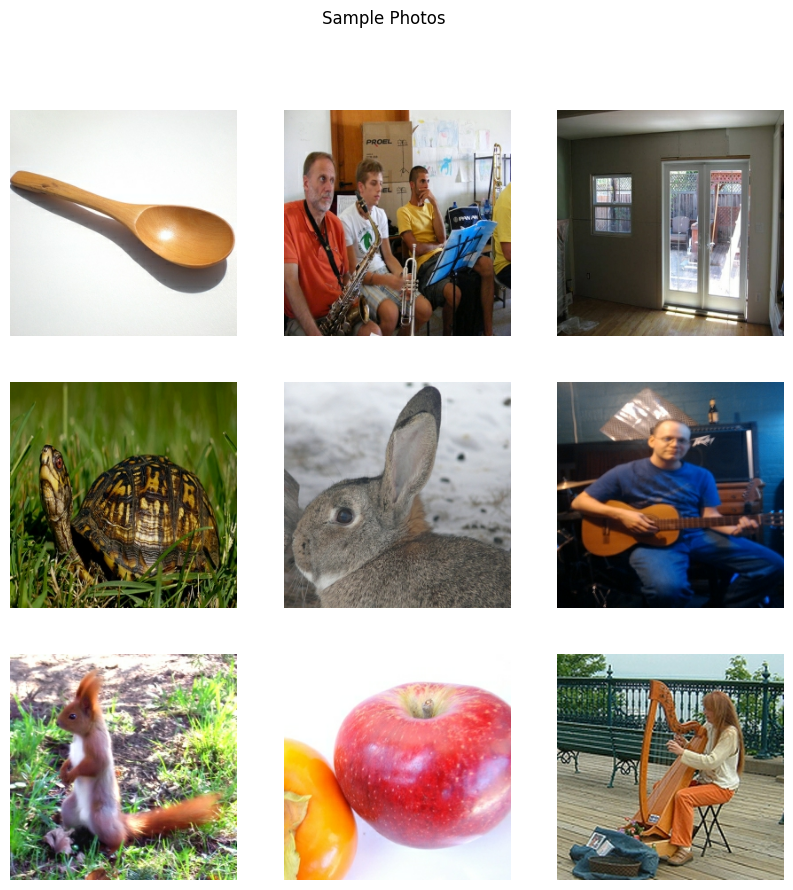

In [10]:
print("Displaying sample photos:")
show_images(photo_dataset, title="Sample Photos")

Displaying sample sketches:


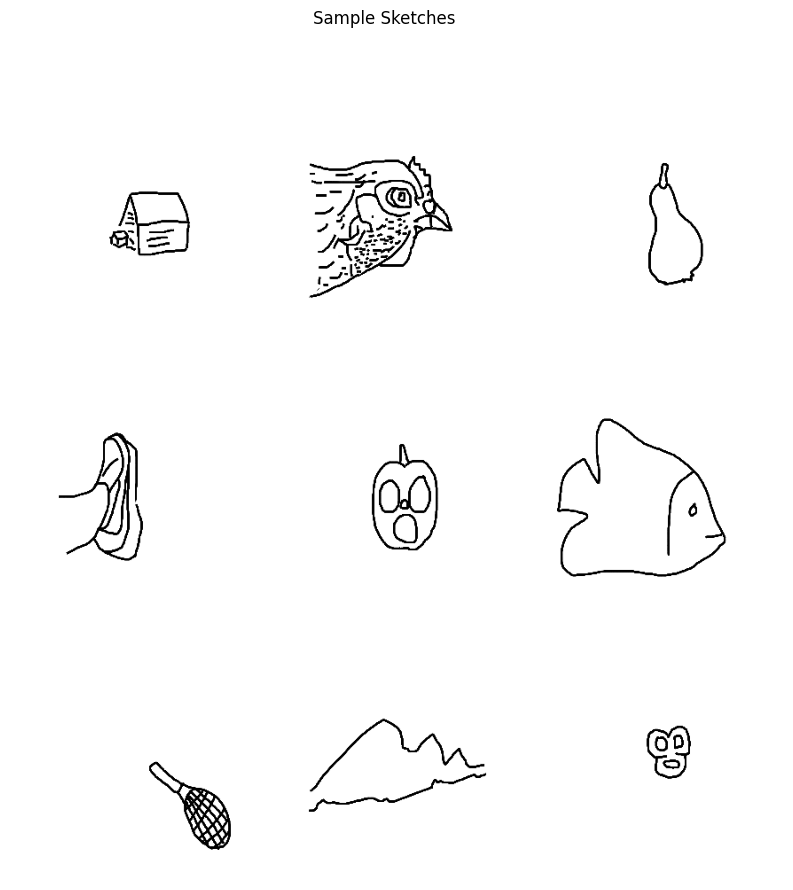

In [11]:
print("Displaying sample sketches:")
show_images(sketch_dataset, title="Sample Sketches")

## Build the Encoders

In [12]:
# Load the pre-trained ResNet-50 model without the top classification layers.
# We use weights from ImageNet and set include_top=False.
base_image_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

# Freeze the base model for now (optional: unfreeze later for fine-tuning)
base_image_model.trainable = False

# Add a global average pooling layer to obtain a fixed-length feature vector.
image_features = layers.GlobalAveragePooling2D()(base_image_model.output)

# Define the image encoder model.
image_encoder = models.Model(
    inputs=base_image_model.input,
    outputs=image_features,
    name='ImageEncoder'
)

# Display the summary of the image encoder model.
image_encoder.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ImageEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
def build_query_encoder(input_shape=(256, 256, 3)):
    """Builds a convolutional neural network encoder for query images.

    Args:
        input_shape (tuple): The shape of the input images (default is (256, 256, 3)).

    Returns:
        tf.keras.Model: The query encoder model.
    """
    inputs = layers.Input(shape=input_shape)

    # First convolutional block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Fourth convolutional block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global average pooling to create a fixed-size vector
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layer to produce the final feature vector
    x = layers.Dense(512, activation='relu')(x)

    return models.Model(inputs=inputs, outputs=x, name='QueryEncoder')

In [14]:
query_encoder = build_query_encoder()
query_encoder.summary()

Model: "QueryEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 520,000 (1.98 MB)

 Trainable params: 520,000 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

## Set Up the GAN Module

#### Generator functions

In [15]:
def build_simple_generator(latent_dim=512, output_dim=2048):
    """Builds a simple generator model for image feature generation from latent features.

    Args:
        latent_dim (int): The size of the input latent vector (default is 512).
        output_dim (int): The size of the output image feature vector (default is 2048).

    Returns:
        tf.keras.Model: The generator model.
    """
    # Input: Sketch (query) features of size latent_dim (default 512)
    query_features = keras.Input(shape=(latent_dim,))

    # First dense layer to learn an intermediate representation.
    x = keras.layers.Dense(1024)(query_features)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)

    # Second dense layer maps the representation to the image feature space.
    image_features = keras.layers.Dense(output_dim)(x)

    # Create and return the generator model.
    generator = keras.Model(query_features, image_features, name="Generator")
    return generator


In [16]:
def build_generator(latent_dim=512):
    """Builds a generator model that generates images from a latent vector.

    Args:
        latent_dim (int): The size of the input latent vector (default is 512).

    Returns:
        tf.keras.Model: The generator model that produces fake images.
    """
    noise = keras.Input(shape=(latent_dim,))
    x = keras.layers.Dense(7 * 7 * 128, activation='relu')(noise)
    x = keras.layers.Reshape((7, 7, 128))(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.UpSampling2D()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.UpSampling2D()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.Conv2D(1, kernel_size=3, padding='same')(x)
    fake_image = keras.layers.Activation('sigmoid')(x)

    generator = keras.Model(noise, fake_image)
    return generator

#### Discriminator functions

In [17]:
def build_simple_discriminator(input_dim=2048):
    """Builds a simple discriminator model that classifies image features as real or fake.

    Args:
        input_dim (int): The size of the input image feature vector (default is 2048).

    Returns:
        tf.keras.Model: The discriminator model that outputs a real/fake probability.
    """

    # Input: Image features (either real from the encoder or generated)
    image_features = keras.Input(shape=(input_dim,))

    # First dense layer to learn an intermediate representation.
    x = keras.layers.Dense(1024)(image_features)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)

    # Second dense layer further processes the features.
    x = keras.layers.Dense(512)(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)

    # Final dense layer outputs a probability of the input being real.
    pred_label = keras.layers.Dense(1, activation='sigmoid')(x)

    # Create and return the discriminator model.
    discriminator = keras.Model(image_features, pred_label, name="Discriminator")
    return discriminator


In [18]:
def build_discriminator(input_dim=2048):
    """Builds a convolutional discriminator model to classify images as real or fake.

    Returns:
        tf.keras.Model: The discriminator model that outputs a real/fake probability.
    """
    img = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Conv2D(16, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same')(img)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(x)
    x = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = keras.layers.LeakyReLU(alpha=0.2)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Flatten()(x)
    pred_label = keras.layers.Dense(1, activation='sigmoid')(x)

    discriminator = keras.Model(img, pred_label)
    return discriminator

#### Loss functions

In [19]:
# Define the Binary Crossentropy loss for the adversarial part.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [21]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    """Calculates the triplet loss for retrieval.

    Args:
        anchor (tf.Tensor): The anchor features (e.g., generated query features).
        positive (tf.Tensor): The positive features (e.g., real image features of the same instance).
        negative (tf.Tensor): The negative features (e.g., real image features of a different instance).
        margin (float): The margin that enforces the required difference between positive and negative distances (default is 1.0).

    Returns:
        tf.Tensor: The mean triplet loss.
    """
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)

    return tf.reduce_mean(loss)

#### Optimizers

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

#### GAN Model

In [23]:
# Instantiate the generator and discriminator.
generator = build_simple_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │       2,099,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,624,512 (10.01 MB)

 Trainable params: 2,624,512 (10.01 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
discriminator = build_simple_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,623,489 (10.01 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, query_encoder, image_encoder, lambda_adv=0.5):
        """
        Initializes the GAN model.
        - discriminator: Model to distinguish between real and generated image features.
        - generator: Model that maps query (sketch) features (512-D) to image feature space (2048-D).
        - query_encoder: Custom CNN that extracts 512-D features from sketch images.
        - image_encoder: Pre-trained image encoder (e.g., ResNet-50) that extracts 2048-D features from photos.
        - lambda_adv: Weighting factor to balance adversarial loss and retrieval (triplet) loss.
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.query_encoder = query_encoder
        self.image_encoder = image_encoder  # Pre-trained and frozen
        self.lambda_adv = lambda_adv
        self.latent_dim = 512  # Dimension of query features

    def compile(self, d_optimizer, g_optimizer, adv_loss_fn, retrieval_loss_fn):
        """
        Compiles the model with optimizers and loss functions.
        - d_optimizer: Optimizer for updating discriminator weights.
        - g_optimizer: Optimizer for updating generator and query encoder weights.
        - adv_loss_fn: Adversarial loss function (e.g., binary crossentropy).
        - retrieval_loss_fn: Retrieval loss function (triplet loss).
        """
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.adv_loss_fn = adv_loss_fn
        self.retrieval_loss_fn = retrieval_loss_fn

    def train_step(self, data):
        """
        Custom training step:
        - data: A tuple (sketch_images, photo_images).
        """
        sketch_images, photo_images = data
        batch_size = tf.shape(sketch_images)[0]

        # Obtain 512-D query features from sketch images using the query encoder.
        query_features = self.query_encoder(sketch_images, training=True)
        # Generate 2048-D image-like features from the query features.
        generated_features = self.generator(query_features, training=True)
        # Extract real 2048-D image features from photo images using the pre-trained image encoder.
        real_features = self.image_encoder(photo_images, training=False)

        # --------------------- Discriminator Update ---------------------
        with tf.GradientTape() as tape:
            # Discriminator predictions for real and generated features.
            real_output = self.discriminator(real_features, training=True)
            fake_output = self.discriminator(generated_features, training=True)
            # Create combined labels: 1 for real features, 0 for fake features.
            combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            combined_outputs = tf.concat([real_output, fake_output], axis=0)
            d_loss = self.adv_loss_fn(combined_labels, combined_outputs)
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # --------------------- Generator and Query Encoder Update ---------------------
        with tf.GradientTape() as tape:
            generated_features = self.generator(query_features, training=True)
            fake_output = self.discriminator(generated_features, training=True)
            # Adversarial loss: try to fool the discriminator.
            g_adv_loss = self.adv_loss_fn(tf.ones((batch_size, 1)), fake_output)
            # Create negative samples by rolling the batch of real features.
            neg_features = tf.roll(real_features, shift=1, axis=0)
            # Compute retrieval (triplet) loss.
            g_retrieval_loss = self.retrieval_loss_fn(generated_features, real_features, neg_features)
            # Total generator loss: combine retrieval and adversarial losses.
            g_loss = g_retrieval_loss + self.lambda_adv * g_adv_loss
        g_vars = self.generator.trainable_variables + self.query_encoder.trainable_variables
        g_grads = tape.gradient(g_loss, g_vars)
        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))

        # Compute discriminator accuracy on combined outputs.
        pred_labels = tf.cast(tf.greater_equal(combined_outputs, 0.5), tf.float32)
        d_accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, combined_labels), tf.float32))

        return {"d_loss": d_loss, "g_loss": g_loss, "d_accuracy": d_accuracy,
                "g_adv_loss": g_adv_loss, "g_retrieval_loss": g_retrieval_loss}

    def test_step(self, data):
        """
        Custom test step for validation/testing:
        - data: A tuple (sketch_images, photo_images).
        """
        sketch_images, photo_images = data
        batch_size = tf.shape(sketch_images)[0]

        query_features = self.query_encoder(sketch_images, training=False)
        generated_features = self.generator(query_features, training=False)
        real_features = self.image_encoder(photo_images, training=False)

        # Discriminator outputs.
        real_output = self.discriminator(real_features, training=False)
        fake_output = self.discriminator(generated_features, training=False)
        combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        combined_outputs = tf.concat([real_output, fake_output], axis=0)
        d_loss = self.adv_loss_fn(combined_labels, combined_outputs)

        # Compute discriminator accuracy.
        pred_labels = tf.cast(tf.greater_equal(combined_outputs, 0.5), tf.float32)
        d_accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, combined_labels), tf.float32))

        # Generator losses.
        g_adv_loss = self.adv_loss_fn(tf.ones((batch_size, 1)), fake_output)
        neg_features = tf.roll(real_features, shift=1, axis=0)
        g_retrieval_loss = self.retrieval_loss_fn(generated_features, real_features, neg_features)
        g_loss = g_retrieval_loss + self.lambda_adv * g_adv_loss

        return {"d_loss": d_loss, "g_loss": g_loss, "d_accuracy": d_accuracy,
                "g_adv_loss": g_adv_loss, "g_retrieval_loss": g_retrieval_loss}

## Sketchy Real Data Training

### Prepare data as list of pairs

In [26]:
# Define selected categories to work on a subset.
selected_categories = ["airplane", "car", "bicycle"]

sketchy_photo_files = tf.io.gfile.glob(os.path.join(dataset_path, '256x256', 'photo', '*', '*', '*.jpg'))
sketchy_sketch_files = tf.io.gfile.glob(os.path.join(dataset_path, '256x256', 'sketch', '*', '*', '*.png'))

sketchy_pairs = []
photo_dict = {}
categories = []

# Process photo files to create a dictionary keyed by (category, object_name)
for photo_file in sketchy_photo_files:
    match = re.search(r'photo/(.+?)/(.+?)/(.+?)\.jpg$', photo_file)
    if match:
        category = match.group(2)
        if category not in categories:  # Check if category is already in the list
          categories.append(category)
        object_name = match.group(3).split('_')[0]  # Extract common part of the object name
        photo_dict[(category, object_name)] = photo_file

# Process sketch files, find matching photos using the key, and filter by selected categories.
for sketch_file in sketchy_sketch_files:
    match = re.search(r'sketch/(.+?)/(.+?)/(.+?)\.png$', sketch_file)
    if match:
        category = match.group(2)
        object_name = match.group(3).split('_')[0]
        # Check if a matching photo exists and if the category is one of the selected ones.
        if (category, object_name) in photo_dict and category in selected_categories:
            sketchy_pairs.append((sketch_file, photo_dict[(category, object_name)]))

print("Total sketch-photo pairs:", len(sketchy_pairs))
print("Unique categories:", len(categories))

Total sketch-photo pairs: 7938
Unique categories: 125


In [27]:
# ---------------------------
# Create a tf.data.Dataset from the paired file paths
# ---------------------------
# Separate the list of pairs into two lists: one for sketches and one for photos.
sketch_paths, photo_paths = zip(*sketchy_pairs)
sketch_paths = list(sketch_paths)
photo_paths = list(photo_paths)

# Create a dataset from these file paths.
paired_dataset = tf.data.Dataset.from_tensor_slices((sketch_paths, photo_paths))

In [28]:
# Define a function to load and preprocess both images.
def load_pair(sketch_path, photo_path):
    """Loads and preprocesses a pair of images (sketch and photo).

    Args:
        sketch_path (str or tf.Tensor): The path to the sketch image.
        photo_path (str or tf.Tensor): The path to the photo image.

    Returns:
        tuple: Preprocessed sketch and photo images.
    """
    # Ensure paths are in string format (in case they are byte tensors)
    sketch_path = sketch_path.numpy().decode('utf-8')
    photo_path = photo_path.numpy().decode('utf-8')
    # Use our previously defined function to load and preprocess images.
    sketch_img = load_and_preprocess_image(sketch_path, image_type='sketch')
    photo_img = load_and_preprocess_image(photo_path, image_type='photo')

    return sketch_img, photo_img

In [29]:
# Wrap the load_pair function so it can be used with tf.data.
def tf_load_pair(sketch_path, photo_path):
    """Wraps the load_pair function for use with tf.data.

    Args:
        sketch_path (tf.Tensor): The path to the sketch image.
        photo_path (tf.Tensor): The path to the photo image.

    Returns:
        tuple: The preprocessed sketch and photo images as tf.Tensors.
    """
    sketch_img, photo_img = tf.py_function(
        func=load_pair, inp=[sketch_path, photo_path], Tout=[tf.float32, tf.float32]
    )
    # Set static shape information for the output images.
    sketch_img.set_shape([256, 256, 3])
    photo_img.set_shape([256, 256, 3])

    return sketch_img, photo_img

In [30]:
def show_paired_images(dataset):
    """Displays a batch of paired sketch and photo images.

    Args:
        dataset (tf.data.Dataset): The dataset containing paired sketch and photo images.
    """
    for sketch_batch, photo_batch in dataset.take(1):
        plt.figure(figsize=(12, 6))
        for i in range(min(6, sketch_batch.shape[0])):
            plt.subplot(2, 6, i + 1)
            plt.imshow((sketch_batch[i].numpy() + 1) / 2.0)
            plt.title("Sketch")
            plt.axis("off")

            plt.subplot(2, 6, i + 7)
            plt.imshow((photo_batch[i].numpy() + 1) / 2.0)
            plt.title("Photo")
            plt.axis("off")
        plt.show()

In [31]:
# Map the dataset to load and preprocess images.
paired_dataset = paired_dataset.map(tf_load_pair, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch for efficient training.
BATCH_SIZE = 32
paired_dataset = paired_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

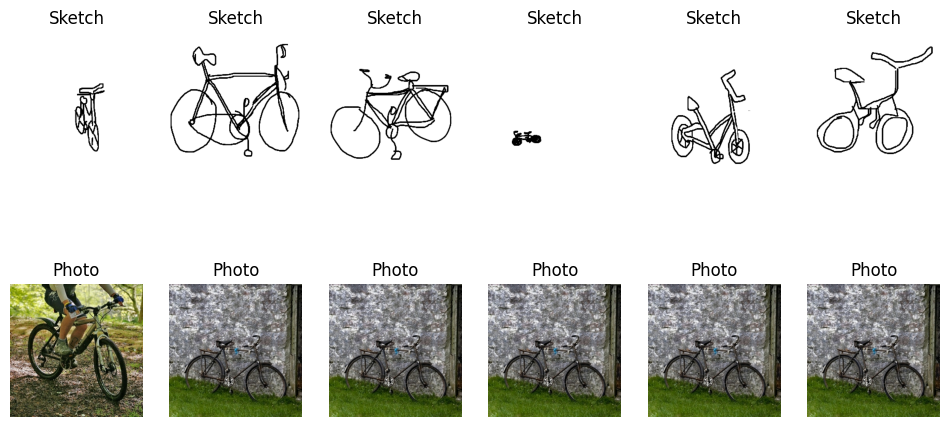

In [32]:
show_paired_images(paired_dataset)

### Execute

In [33]:
# Splitting the Dataset into Training, Validation, and Test Sets
# Assume 'paired_dataset' is our tf.data.Dataset containing (sketch_image, photo_image) pairs.
# Ensure that paired_dataset has a known cardinality.
dataset_size = paired_dataset.cardinality().numpy()  # Make sure this returns a valid integer
test_ratio = 0.1
val_ratio = 0.1
test_size = math.floor(test_ratio * dataset_size)
val_size = math.floor(val_ratio * dataset_size)

# Create test, validation, and training datasets.
test_dataset = paired_dataset.take(test_size)
val_dataset = paired_dataset.skip(test_size).take(val_size)
train_dataset = paired_dataset.skip(test_size + val_size)

print(f"Training dataset size: {train_dataset.cardinality().numpy()}")
print(f"Validation dataset size: {val_dataset.cardinality().numpy()}")
print(f"Test dataset size: {test_dataset.cardinality().numpy()}")

Training dataset size: 201
Validation dataset size: 24
Test dataset size: 24


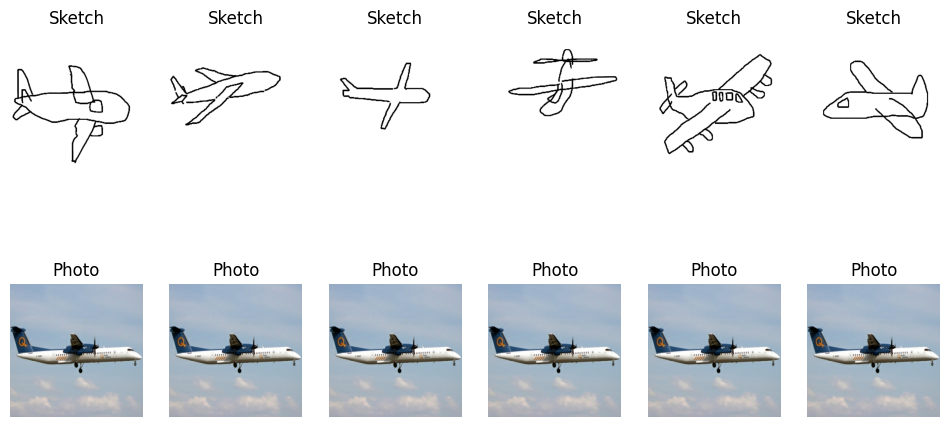

In [34]:
show_paired_images(train_dataset)

In [35]:
# Set Up Callbacks for Saving and Logging
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "gan_best_weights.weights.h5",
    save_best_only=True,
    monitor='val_g_loss',
    mode='min',
    save_weights_only=True,
    verbose=1
)
checkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    "gan_best_model.keras",
    save_best_only=True,
    monitor='val_g_loss',
    mode='min',
    save_weights_only=False,
    verbose=1
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_g_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='./logs')

callbacks = [earlystop_cb, tensorboard_cb]

In [36]:
gan = GAN(discriminator, generator, query_encoder, image_encoder, lambda_adv=0.5)

In [37]:
gan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer,
            adv_loss_fn=cross_entropy, retrieval_loss_fn=triplet_loss)

In [38]:
EPOCHS = 10

gan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['conv2d/kernel', 'conv2d/bias', 'conv2d_1/kernel', 'conv2d_1/bias', 'conv2d_2/kernel', 'conv2d_2/bias', 'conv2d_3/kernel', 'conv2d_3/bias', 'dense/kernel', 'dense/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


201/201 ━━━━━━━━━━━━━━━━━━━━ 91s 345ms/step - d_accuracy: 0.9603 - d_loss: 0.0623 - g_adv_loss: 5.1701 - g_loss: 11.0329 - g_retrieval_loss: 8.4478 - val_d_accuracy: 1.0000 - val_d_loss: 0.0016 - val_g_adv_loss: 5.8785 - val_g_loss: 3.9392 - val_g_retrieval_loss: 1.0000
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - d_accuracy: 1.0000 - d_loss: 0.0011 - g_adv_loss: 8.1277 - g_loss: 10.0510 - g_retrieval_loss: 5.9872 - val_d_accuracy: 1.0000 - val_d_loss: 6.2425e-04 - val_g_adv_loss: 7.1763 - val_g_loss: 4.5881 - val_g_retrieval_loss: 1.0000
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 71s 325ms/step - d_accuracy: 1.0000 - d_loss: 5.9495e-04 - g_adv_loss: 9.6015 - g_loss: 8.4342 - g_retrieval_loss: 3.6335 - val_d_accuracy: 1.0000 - val_d_loss: 2.6347e-04 - val_g_adv_loss: 8.1175 - val_g_loss: 5.0587 - val_g_retrieval_loss: 1.0000
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 69s 306ms/step - d_accuracy: 1.0000 - d_loss: 3.8204e-04 - g_adv_loss: 10.3136 - g_loss: 9.0148 - g_retrieval_loss

In [39]:
# Evaluate on Test Data and Save Final Weights
test_results = gan.evaluate(test_dataset)
print("Test results:", test_results)

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - d_accuracy: 1.0000 - d_loss: 0.0017 - g_adv_loss: 6.6035 - g_loss: 14.9434 - g_retrieval_loss: 11.6417
Test results: [<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.002153105800971389>, <tf.Tensor: shape=(), dtype=float32, numpy=5.881241321563721>, <tf.Tensor: shape=(), dtype=float32, numpy=3.9406206607818604>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>]


Overall Impression:

- The decreasing retrieval loss is a positive sign for your cross-modal retrieval task because it indicates that the generator is learning to bring the sketch features closer to the corresponding photo features.

- The high discriminator accuracy suggests that the adversarial part of the training is strongly favoring the discriminator, which is common in many GAN settings.

- Given that our main goal is to improve retrieval performance (as measured by the triplet loss), these results are encouraging.

In [40]:
gan.save("gan_model_1.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [41]:
def extract_features(dataset, mode='sketch'):
    """
    Extract features from the given dataset.
    If mode=='sketch', we extract features using the query_encoder and generator.
    If mode=='photo', we extract features using the frozen image_encoder.
    Returns a numpy array of features for all examples.
    """
    features_list = []
    for sketches, photos in dataset:
        if mode == 'sketch':
            # Extract 512-D features from sketches, then map to image space using the generator.
            query_feats = gan.query_encoder(sketches, training=False)
            gen_feats = gan.generator(query_feats, training=False)
            features_list.append(gen_feats.numpy())
        elif mode == 'photo':
            # Extract 2048-D features directly from photos using the image encoder.
            feats = gan.image_encoder(photos, training=False)
            features_list.append(feats.numpy())
    return np.concatenate(features_list, axis=0)

def cosine_similarity(a, b):
    """
    Compute cosine similarity between two sets of feature vectors.
    a: NumPy array of shape (num_examples, feature_dim)
    b: NumPy array of shape (num_examples, feature_dim)
    Returns a similarity matrix of shape (num_examples, num_examples)
    """
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a_norm, b_norm.T)

In [42]:
# Extract features for test sketches and test photos.
test_sketch_features = extract_features(test_dataset, mode='sketch')
test_photo_features = extract_features(test_dataset, mode='photo')

# Compute cosine similarity matrix between each test sketch and all test photos.
similarity_matrix = cosine_similarity(test_sketch_features, test_photo_features)

# For each sketch, find the index of the most similar photo.
retrieved_indices = np.argmax(similarity_matrix, axis=1)

# Since our test set is built from paired data with matching ordering,
# the true matching photo for each sketch is at the same index.
true_indices = np.arange(len(test_sketch_features))

# Compute retrieval accuracy: proportion of sketches for which the top-retrieved photo is the correct one.
retrieval_accuracy = np.mean(retrieved_indices == true_indices)
print("Retrieval Accuracy (Precision@1) on Test Data: {:.2%}".format(retrieval_accuracy))

Retrieval Accuracy (Precision@1) on Test Data: 0.13%


A retrieval accuracy of 0.13% is extremely low and suggests that the alignment between the sketch features and photo features is not working as intended.

In [43]:
# Hard Negative Triplet Loss Function
def hard_triplet_loss(anchor, positive, margin=1.0):
    """
    For each anchor-positive pair, find the hardest negative in the batch (i.e. the one
    that is closest to the anchor) and compute the triplet loss.
    Features are first L2-normalized.
    """
    # Normalize features
    anchor_norm = tf.math.l2_normalize(anchor, axis=1)
    positive_norm = tf.math.l2_normalize(positive, axis=1)

    # Compute pairwise squared Euclidean distances between anchors and positives.
    # dists shape: (batch_size, batch_size)
    dists = tf.reduce_sum(tf.square(tf.expand_dims(anchor_norm, 1) - tf.expand_dims(positive_norm, 0)), axis=2)
    batch_size = tf.shape(anchor)[0]

    # Create a mask to ignore the diagonal (i.e., the true positive for each anchor)
    mask = 1.0 - tf.eye(batch_size)
    # Set diagonal entries to a large value so they are not chosen as negatives.
    dists_neg = dists + (1.0 - mask) * 1e6

    # For each anchor, get the minimum distance among negatives (hardest negative).
    hardest_neg = tf.reduce_min(dists_neg, axis=1)
    # The positive distance is the diagonal of the distance matrix.
    d_pos = tf.linalg.diag_part(dists)

    # Compute the triplet loss for each sample and take the mean.
    losses = tf.maximum(d_pos - hardest_neg + margin, 0.0)
    return tf.reduce_mean(losses)

# Updated GAN Model Class (using hard_triplet_loss and lower lambda_adv)
class GAN(keras.Model):
    def __init__(self, discriminator, generator, query_encoder, image_encoder, lambda_adv=0.2):
        """
        Initializes the GAN model.
        - discriminator: distinguishes real from generated image features.
        - generator: maps 512-D sketch features to 2048-D image-like features.
        - query_encoder: extracts 512-D features from sketches.
        - image_encoder: pre-trained (and frozen) image encoder for photos.
        - lambda_adv: weight for adversarial loss relative to retrieval loss.
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.query_encoder = query_encoder
        self.image_encoder = image_encoder
        self.lambda_adv = lambda_adv
        self.latent_dim = 512

    def compile(self, d_optimizer, g_optimizer, adv_loss_fn, retrieval_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.adv_loss_fn = adv_loss_fn
        self.retrieval_loss_fn = retrieval_loss_fn

    def train_step(self, data):
        sketch_images, photo_images = data
        batch_size = tf.shape(sketch_images)[0]

        # Obtain query features from sketches.
        query_features = self.query_encoder(sketch_images, training=True)
        # Map sketch features to image feature space.
        generated_features = self.generator(query_features, training=True)
        # Get real image features.
        real_features = self.image_encoder(photo_images, training=False)

        # --------------------- Update Discriminator ---------------------
        with tf.GradientTape() as tape:
            real_output = self.discriminator(real_features, training=True)
            fake_output = self.discriminator(generated_features, training=True)
            # Labels: 1 for real, 0 for fake.
            combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            combined_outputs = tf.concat([real_output, fake_output], axis=0)
            d_loss = self.adv_loss_fn(combined_labels, combined_outputs)
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # --------------------- Update Generator & Query Encoder ---------------------
        with tf.GradientTape() as tape:
            # Recompute generated features.
            generated_features = self.generator(query_features, training=True)
            fake_output = self.discriminator(generated_features, training=True)
            # Adversarial loss: aim to fool the discriminator.
            g_adv_loss = self.adv_loss_fn(tf.ones((batch_size, 1)), fake_output)
            # Use hard negative triplet loss between generated features and real features.
            g_retrieval_loss = self.retrieval_loss_fn(generated_features, real_features)
            g_loss = g_retrieval_loss + self.lambda_adv * g_adv_loss
        g_vars = self.generator.trainable_variables + self.query_encoder.trainable_variables
        g_grads = tape.gradient(g_loss, g_vars)
        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))

        # Compute discriminator accuracy.
        pred_labels = tf.cast(tf.greater_equal(combined_outputs, 0.5), tf.float32)
        d_accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, combined_labels), tf.float32))

        # Return a dictionary of metrics with an explicit "loss" key.
        return {
            "loss": d_loss + g_loss,
            "d_loss": d_loss,
            "g_loss": g_loss,
            "d_accuracy": d_accuracy,
            "g_adv_loss": g_adv_loss,
            "g_retrieval_loss": g_retrieval_loss,
        }

    def test_step(self, data):
        sketch_images, photo_images = data
        batch_size = tf.shape(sketch_images)[0]
        query_features = self.query_encoder(sketch_images, training=False)
        generated_features = self.generator(query_features, training=False)
        real_features = self.image_encoder(photo_images, training=False)
        real_output = self.discriminator(real_features, training=False)
        fake_output = self.discriminator(generated_features, training=False)
        combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        combined_outputs = tf.concat([real_output, fake_output], axis=0)
        d_loss = self.adv_loss_fn(combined_labels, combined_outputs)
        pred_labels = tf.cast(tf.greater_equal(combined_outputs, 0.5), tf.float32)
        d_accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, combined_labels), tf.float32))
        g_adv_loss = self.adv_loss_fn(tf.ones((batch_size, 1)), fake_output)
        g_retrieval_loss = self.retrieval_loss_fn(generated_features, real_features)
        g_loss = g_retrieval_loss + self.lambda_adv * g_adv_loss
        return {
            "loss": d_loss + g_loss,
            "d_loss": d_loss,
            "g_loss": g_loss,
            "d_accuracy": d_accuracy,
            "g_adv_loss": g_adv_loss,
            "g_retrieval_loss": g_retrieval_loss,
        }

# Update Feature Extraction for Evaluation (with normalization)
def extract_features(dataset, mode='sketch'):
    """
    Extract features from the dataset.
    - For 'sketch': extract using query_encoder then generator.
    - For 'photo': extract using the frozen image_encoder.
    Features are L2-normalized.
    """
    features_list = []
    for sketches, photos in dataset:
        if mode == 'sketch':
            query_feats = gan.query_encoder(sketches, training=False)
            gen_feats = gan.generator(query_feats, training=False)
            gen_feats = tf.math.l2_normalize(gen_feats, axis=1)
            features_list.append(gen_feats.numpy())
        elif mode == 'photo':
            feats = gan.image_encoder(photos, training=False)
            feats = tf.math.l2_normalize(feats, axis=1)
            features_list.append(feats.numpy())
    return np.concatenate(features_list, axis=0)

def cosine_similarity(a, b):
    """Compute cosine similarity between two arrays of normalized feature vectors."""
    return np.dot(a, b.T)

# Extract features for test sketches and test photos.
test_sketch_features = extract_features(test_dataset, mode='sketch')
test_photo_features = extract_features(test_dataset, mode='photo')

# Compute cosine similarity matrix.
similarity_matrix = cosine_similarity(test_sketch_features, test_photo_features)
retrieved_indices = np.argmax(similarity_matrix, axis=1)
true_indices = np.arange(len(test_sketch_features))
retrieval_accuracy = np.mean(retrieved_indices == true_indices)
print("Retrieval Accuracy (Precision@1) on Test Data: {:.2%}".format(retrieval_accuracy))

Retrieval Accuracy (Precision@1) on Test Data: 0.13%


Still extremely low retrieval accuracy indicates that the current setup isn’t aligning the sketch and photo features effectively.

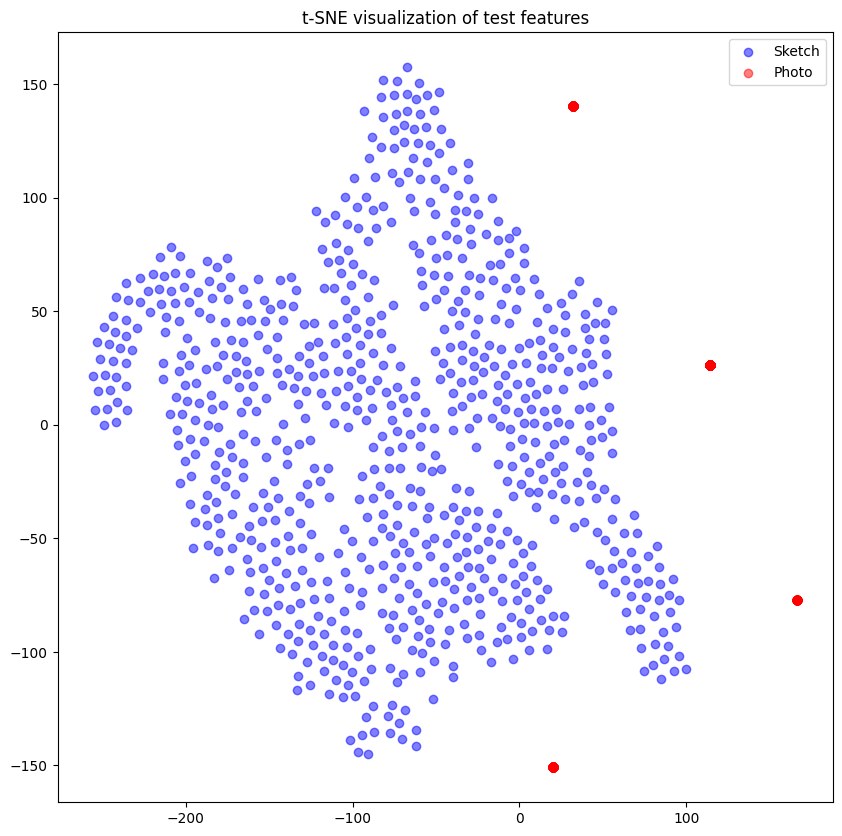

In [44]:
# Extract features for test sketches and photos (features are L2-normalized)
test_sketch_features = extract_features(test_dataset, mode='sketch')
test_photo_features = extract_features(test_dataset, mode='photo')

# Concatenate features for visualization
combined_features = np.concatenate([test_sketch_features, test_photo_features], axis=0)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(combined_features)

n = test_sketch_features.shape[0]

plt.figure(figsize=(10,10))
plt.scatter(tsne_results[:n, 0], tsne_results[:n, 1], label='Sketch', alpha=0.5, c='blue')
plt.scatter(tsne_results[n:, 0], tsne_results[n:, 1], label='Photo', alpha=0.5, c='red')
plt.legend()
plt.title('t-SNE visualization of test features')
plt.show()

### Update GAN Model with generator and discriminator

In [45]:
# Instantiate the generator and discriminator.
generator = build_generator()
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6272)                │       3,217,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 1)           │             577 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,440,769 (13.13 MB)

 Trainable params: 3,440,129 (13.12 MB)

 Non-trainable params: 640 (2.50 KB)

In [46]:
discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,585 (389.00 KB)

 Trainable params: 99,393 (388.25 KB)

 Non-trainable params: 192 (768.00 B)

In [47]:
'''
class GAN(keras.Model):
    def __init__(self, discriminator, generator, query_encoder, image_encoder, lambda_adv=0.5):
        """
        Initializes the GAN model.
        - discriminator: Model to distinguish between real and generated image features.
        - generator: Model that maps query (sketch) features (512-D) to image feature space (2048-D).
        - query_encoder: Custom CNN that extracts 512-D features from sketch images.
        - image_encoder: Pre-trained image encoder (e.g., ResNet-50) that extracts 2048-D features from photos.
        - lambda_adv: Weighting factor to balance adversarial loss and retrieval (triplet) loss.
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.query_encoder = query_encoder
        self.image_encoder = image_encoder  # Pre-trained and frozen
        self.lambda_adv = lambda_adv
        self.latent_dim = 512  # Dimension of query features

    def compile(self, d_optimizer, g_optimizer, adv_loss_fn, retrieval_loss_fn):
        """
        Compiles the model with optimizers and loss functions.
        - d_optimizer: Optimizer for updating discriminator weights.
        - g_optimizer: Optimizer for updating generator and query encoder weights.
        - adv_loss_fn: Adversarial loss function (e.g., binary crossentropy).
        - retrieval_loss_fn: Retrieval loss function (triplet loss).
        """
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.adv_loss_fn = adv_loss_fn
        self.retrieval_loss_fn = retrieval_loss_fn

    def train_step(self, data):
        """
        Custom training step:
        - data: A tuple (sketch_images, photo_images).
        """
        sketch_images, photo_images = data
        batch_size = tf.shape(sketch_images)[0]

        # Obtain 512-D query features from sketch images using the query encoder.
        query_features = self.query_encoder(sketch_images, training=True)
        # Generate 2048-D image-like features from the query features.
        generated_features = self.generator(query_features, training=True)
        # Extract real 2048-D image features from photo images using the pre-trained image encoder.
        real_features = self.image_encoder(photo_images, training=False)

        # --------------------- Discriminator Update ---------------------
        with tf.GradientTape() as tape:
            # Discriminator predictions for real and generated features.
            real_output = self.discriminator(real_features, training=True)
            fake_output = self.discriminator(generated_features, training=True)
            # Create combined labels: 1 for real features, 0 for fake features.
            combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
            combined_outputs = tf.concat([real_output, fake_output], axis=0)
            d_loss = self.adv_loss_fn(combined_labels, combined_outputs)
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # --------------------- Generator and Query Encoder Update ---------------------
        with tf.GradientTape() as tape:
            generated_features = self.generator(query_features, training=True)
            fake_output = self.discriminator(generated_features, training=True)
            # Adversarial loss: try to fool the discriminator.
            g_adv_loss = self.adv_loss_fn(tf.ones((batch_size, 1)), fake_output)
            # Create negative samples by rolling the batch of real features.
            neg_features = tf.roll(real_features, shift=1, axis=0)
            # Compute retrieval (triplet) loss.
            g_retrieval_loss = self.retrieval_loss_fn(generated_features, real_features, neg_features)
            # Total generator loss: combine retrieval and adversarial losses.
            g_loss = g_retrieval_loss + self.lambda_adv * g_adv_loss
        g_vars = self.generator.trainable_variables + self.query_encoder.trainable_variables
        g_grads = tape.gradient(g_loss, g_vars)
        self.g_optimizer.apply_gradients(zip(g_grads, g_vars))

        # Compute discriminator accuracy on combined outputs.
        pred_labels = tf.cast(tf.greater_equal(combined_outputs, 0.5), tf.float32)
        d_accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, combined_labels), tf.float32))

        return {"d_loss": d_loss, "g_loss": g_loss, "d_accuracy": d_accuracy,
                "g_adv_loss": g_adv_loss, "g_retrieval_loss": g_retrieval_loss}

    def test_step(self, data):
        """
        Custom test step for validation/testing:
        - data: A tuple (sketch_images, photo_images).
        """
        sketch_images, photo_images = data
        batch_size = tf.shape(sketch_images)[0]

        query_features = self.query_encoder(sketch_images, training=False)
        generated_features = self.generator(query_features, training=False)
        real_features = self.image_encoder(photo_images, training=False)

        # Discriminator outputs.
        real_output = self.discriminator(real_features, training=False)
        fake_output = self.discriminator(generated_features, training=False)
        combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        combined_outputs = tf.concat([real_output, fake_output], axis=0)
        d_loss = self.adv_loss_fn(combined_labels, combined_outputs)

        # Compute discriminator accuracy.
        pred_labels = tf.cast(tf.greater_equal(combined_outputs, 0.5), tf.float32)
        d_accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, combined_labels), tf.float32))

        # Generator losses.
        g_adv_loss = self.adv_loss_fn(tf.ones((batch_size, 1)), fake_output)
        neg_features = tf.roll(real_features, shift=1, axis=0)
        g_retrieval_loss = self.retrieval_loss_fn(generated_features, real_features, neg_features)
        g_loss = g_retrieval_loss + self.lambda_adv * g_adv_loss

        return {"d_loss": d_loss, "g_loss": g_loss, "d_accuracy": d_accuracy,
                "g_adv_loss": g_adv_loss, "g_retrieval_loss": g_retrieval_loss}
                '''

In [48]:
gan = GAN(discriminator, generator, query_encoder, image_encoder, lambda_adv=0.2)

In [49]:
gan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer,
            adv_loss_fn=cross_entropy, retrieval_loss_fn=triplet_loss)

In [50]:
gan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 2048)

In [ ]:
# Evaluate on Test Data and Save Final Weights
test_results = gan.evaluate(test_dataset)
print("Test results:", test_results)

In [ ]:
gan.save("gan_model_2.keras")

In [ ]:
# Extract features for test sketches and test photos.
test_sketch_features = extract_features(test_dataset, mode='sketch')
test_photo_features = extract_features(test_dataset, mode='photo')

# Compute cosine similarity matrix between each test sketch and all test photos.
similarity_matrix = cosine_similarity(test_sketch_features, test_photo_features)

# For each sketch, find the index of the most similar photo.
retrieved_indices = np.argmax(similarity_matrix, axis=1)

# Since our test set is built from paired data with matching ordering,
# the true matching photo for each sketch is at the same index.
true_indices = np.arange(len(test_sketch_features))

# Compute retrieval accuracy: proportion of sketches for which the top-retrieved photo is the correct one.
retrieval_accuracy = np.mean(retrieved_indices == true_indices)
print("Retrieval Accuracy (Precision@1) on Test Data: {:.2%}".format(retrieval_accuracy))